In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the finetune performance

In [2]:
mask_ratios = range(10, 100, 10)
lrs = ["1e-4", "1e-5", "1e-6"]
transforms = ["instance_normalize", "normalize", "log"]
targets = ["CaCO3", "TOC"]

rows = []

for mask_ratio in mask_ratios:
    for lr in lrs:
        for t in transforms:
            for target in targets:
                with open(f"../results/finetune_pretrained/pretrain-mask-ratio-{mask_ratio/100}-blr-{lr}-transform-{t}/{target}/{target}.txt") as f:
                    words = f.readline().split()
                    r_square = float(words[-1])
                    rows.append([mask_ratio/100, float(lr), t, target, r_square])
df = pd.DataFrame(rows, columns=["mask_ratio", "lr", "transform", "target", "r_square"])
print(df.head())
print(df.shape)
#df.to_csv("../finetune_pretrained.csv")

   mask_ratio      lr           transform target  r_square
0         0.1  0.0001  instance_normalize  CaCO3     0.968
1         0.1  0.0001  instance_normalize    TOC     0.777
2         0.1  0.0001           normalize  CaCO3     0.971
3         0.1  0.0001           normalize    TOC     0.729
4         0.1  0.0001                 log  CaCO3     0.969
(162, 5)


# Plot the optimal model's $R^{2}$ in each mask ratio
As discussed, I adopt the method 3 in `finetune_05.ipynb` to select the optimal model. 3-1 First average the $R^{2}$ values of CaCO3 and TOC produced by each pre-trained model, then separate three different transforms, take the best average $R^{2}$ value in each mask ratio and plot them. In this way, we avoid the averaging of two different pre-trained models' performance.

3-2 Based on these averaged $R^{2}$ values, I pick the optimal model in each mask ratio. 

1-1 Simply plot the optimal models' $R^{2}$ values in each mask ratio, transform, and target.

In [14]:
r2_mean_df = pd.DataFrame()
for i in range(0, len(df), 2):
    r2_mean = df.loc[i:i+1, "r_square"].mean()
    tmp_df = df.iloc[i, :3].copy()
    tmp_df["r2_mean"] = r2_mean
    r2_mean_df = pd.concat([r2_mean_df, tmp_df], axis=1)

r2_mean_df = r2_mean_df.T.reset_index(drop=True)
r2_mean_df

,mask_ratio,lr,transform,r2_mean
0,0.1,0.0001,instance_normalize,0.8725
1,0.1,0.0001,normalize,0.85
2,0.1,0.0001,log,0.7405
3,0.1,0.00001,instance_normalize,0.9025
4,0.1,0.00001,normalize,0.8615
...,...,...,...,...
76,0.9,0.00001,normalize,0.875
77,0.9,0.00001,log,0.9075
78,0.9,0.000001,instance_normalize,0.6425
79,0.9,0.000001,normalize,0.656


In [15]:
r2_mean_df.sort_values("r2_mean", ascending=False)[:15]

,mask_ratio,lr,transform,r2_mean
36,0.5,0.0001,instance_normalize,0.9265
45,0.6,0.0001,instance_normalize,0.9145
21,0.3,0.00001,instance_normalize,0.9115
39,0.5,0.00001,instance_normalize,0.9105
48,0.6,0.00001,instance_normalize,0.91
66,0.8,0.00001,instance_normalize,0.909
18,0.3,0.0001,instance_normalize,0.909
77,0.9,0.00001,log,0.9075
30,0.4,0.00001,instance_normalize,0.905
54,0.7,0.0001,instance_normalize,0.904


In [16]:
r2_mean_df[(r2_mean_df["transform"] == "instance_normalize") & (r2_mean_df["mask_ratio"] == 0.7)]

,mask_ratio,lr,transform,r2_mean
54,0.7,0.0001,instance_normalize,0.904
57,0.7,0.00001,instance_normalize,0.901
60,0.7,0.000001,instance_normalize,0.6475


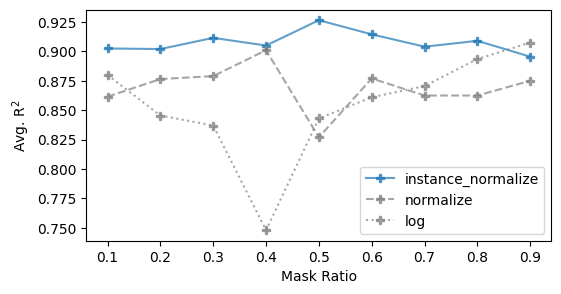

In [42]:
# 3-1 plot
# This one ignores lr

styles = dict(
    marker = ["P", "P", "P"],
    linestyle = ["-", "--", ":"],
    c=["C0", "gray", "gray"]
)

plt.figure(figsize=(6, 3))

for i, t in enumerate(transforms):
    mask = r2_mean_df["transform"] == t
    r2_mean_ratios = r2_mean_df[mask].groupby("mask_ratio").apply(lambda x: x["r2_mean"].max(), include_groups=False).copy()
    plt.plot(
        r2_mean_ratios.index, r2_mean_ratios, label=t, 
        marker=styles["marker"][i], linestyle=styles["linestyle"][i], 
        c=styles["c"][i], alpha=0.7)

plt.xlabel("Mask Ratio")
plt.ylabel("Avg. R$^2$")
plt.legend()

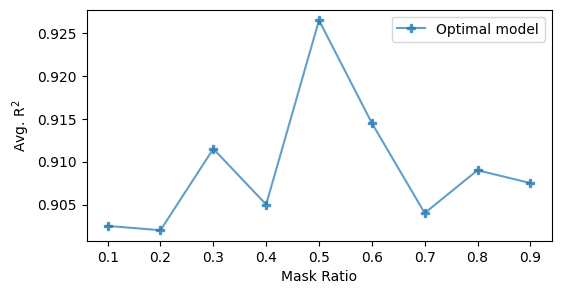

In [43]:
# 3-2 plot
# This one I don't care lr and transform
plt.figure(figsize=(6, 3))

r2_mean_ratios = r2_mean_df.groupby("mask_ratio").apply(lambda x: x["r2_mean"].max(), include_groups=False).copy()
plt.plot(r2_mean_ratios.index, r2_mean_ratios, label="Optimal model", marker="P", alpha=0.7)

plt.xlabel("Mask Ratio")
plt.ylabel("Avg. R$^2$")
plt.legend()

In [19]:
r2_mean_df.loc[r2_mean_df["r2_mean"].idxmax()]

mask_ratio                   0.5
lr                        0.0001
transform     instance_normalize
r2_mean                   0.9265
Name: 36, dtype: object

As an update, we choose the model pre-trained with 0.5 mask ratio, instance_normalize transform and 0.0001 lr as the optimal model for fine-tuning.

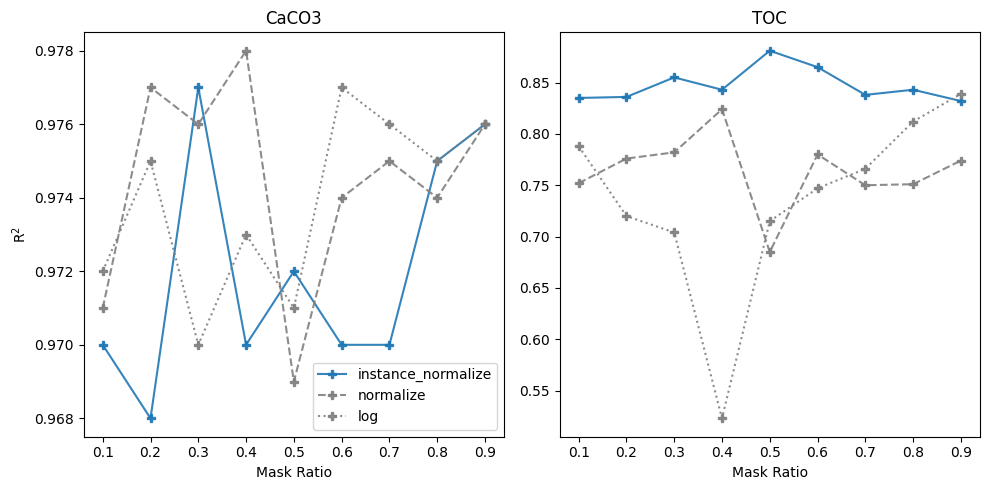

In [44]:
# 1-1 plot
styles = dict(
    marker = ["P", "P", "P"],
    linestyle = ["-", "--", ":"],
    c=["C0", "gray", "gray"]
)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax, target in zip(axes, targets):
    for i, t in enumerate(transforms):
        mask = (df["transform"] == t) & (df["target"] == target)
        best_r2_df = df[mask].groupby("mask_ratio").apply(lambda x: x.loc[x["r_square"].idxmax()], include_groups=False).copy()
        ax.plot(
            best_r2_df.index, best_r2_df["r_square"], 
            label=t, marker=styles["marker"][i], linestyle=styles["linestyle"][i],
            c=styles["c"][i], alpha=0.9)
        ax.set_title(target)

    ax.set_xlabel("Mask Ratio")

axes[0].legend()
axes[0].set_ylabel("R$^2$")
plt.tight_layout()

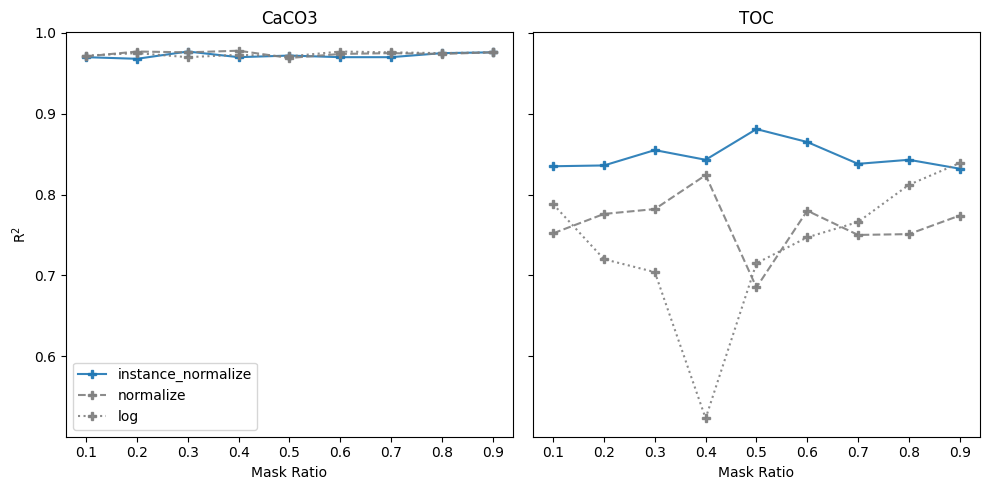

In [45]:
# 1-1 plot
styles = dict(
    marker = ["P", "P", "P"],
    linestyle = ["-", "--", ":"],
    c=["C0", "gray", "gray"]
)

fig, axes = plt.subplots(1, 2, sharey="row", figsize=(10, 5))

for ax, target in zip(axes, targets):
    for i, t in enumerate(transforms):
        mask = (df["transform"] == t) & (df["target"] == target)
        best_r2_df = df[mask].groupby("mask_ratio").apply(lambda x: x.loc[x["r_square"].idxmax()], include_groups=False).copy()
        ax.plot(
            best_r2_df.index, best_r2_df["r_square"], 
            label=t, marker=styles["marker"][i], linestyle=styles["linestyle"][i],
            c=styles["c"][i], alpha=0.9)
        ax.set_title(target)

    ax.set_xlabel("Mask Ratio")

axes[0].legend()
axes[0].set_ylabel("R$^2$")
plt.tight_layout()